# Custom Simulations

Some features in AutoEmuluate can be run simply on data where as other require a simulation to be run. For example, features such as *active learning* and *history matching* require the user to provide a simulator that can be run by AutoEmulate. This tutorial will step through how to do this. 


## The Simulator Class

The simulator class is a Base Python Class that can be inherited to create a custom simulator. The simulator class requires the user to implement the following: 

- `parameter_range`: A parameter set at class inititation. A dictionary of str to tuple pairs. The string is the name of the prameter and the tuple is the min and max value of the parameter. A range is given because the simulator will sample prior to running the simulation from this distribution.
- `output_variables`: A parameter set at class initiation. A list of strings that are the names of the outputs that the simulator will return.
- `_forward`: An abstract method that must be implemented by the user. This method will define a single forward pass of the simulation, taking in the input parameters and returning the output variables. *There are some important rules for this method:*
  - The input to the method must be a tensor of shape `(1, n)` where `n` is the number of input parameters.
  - The output of th method must be a tensor of shape `(1, m)` where `m` is the number of output variables. 
  - If the simulation fails, it must output `None`.


Below is an example of a custom simulator that can be used with AutoEmulate. 

The example is a projectile simulation, where we will simulate the distance travelled of a trajectory given its angle and velocity. 

In [3]:
from autoemulate.experimental.simulations.base import Simulator
import torch

In [ ]:
class Projectile(Simulator):
    """
    Simulator of projectile motion.
    """

    def __init__(
        self,
        param_ranges,
        output_names,
    ):
        super().__init__(param_ranges, output_names)

    def _forward(self, x):
        """
        Calculate the horizontal distance a projectile travels using PyTorch.

        Parameters:
            velocity (float or torch.Tensor): Initial velocity in m/s.
            angle_degrees (float or torch.Tensor): Launch angle in degrees.

        Returns:
            torch.Tensor: Distance traveled in meters.
        """
        # Extract velocity and angle from input tensor
        angle_degrees = x[:, 0]
        velocity = x[:, 1]

        # Convert angle from degrees to radians and calculate distance
        angle_radians = torch.deg2rad(angle_degrees)

        # Calculate the distance using the projectile motion formula
        distance = (velocity ** 2) * torch.sin(2 * angle_radians) / 9.81

        # Ensure the output is a 2D tensor
        if distance.ndim == 1:
            distance = distance.unsqueeze(1)
        return distance


In [41]:
param_ranges = {"angle": (5, 85), "velocity": (0.0, 1000)}
output_names = ["distance"]

projectile_simulator = Projectile(
    param_ranges=param_ranges,
    output_names=output_names,
)

## What can the simulator do?

The first thing to do is sample inputs from the parameter space. In the following cell, we sample 10 times. This is appended into a single tensor of shape `(10, 2)` where the first column is the angle and the second column is the velocity. 

The `input_samples` method implements a latin hypercube sampling method to sample the input parameters. However, if you have a preferred sampling method, you can simply override the method.  

```
 

In [42]:
input_samples = projectile_simulator.sample_inputs(10)

In [43]:
input_samples.shape

torch.Size([10, 2])

These input samples can now be passed to the simulator to run a simulation. The `forward` method will simulate a single forward pass of the simulation whereas `forward_batch` will simulate a batch of forward passes. 



In [ ]:
single_output = projectile_simulator.forward(
    input_samples[0:1]
)

print(single_output)
single_output.shape

tensor([[6858.6431]])


torch.Size([1, 1])

In [49]:
multiple_output = projectile_simulator.forward_batch(
    input_samples
)

print(multiple_output)
multiple_output.shape

Running simulations: 100%|██████████| 10/10 [00:00<00:00, 3426.16it/s]

Successfully completed 10/10 simulations (100.0%)
tensor([[6.8586e+03],
        [4.8887e+04],
        [2.4011e+04],
        [2.4522e+04],
        [3.6851e+04],
        [4.2568e+03],
        [1.8248e+01],
        [7.6757e+04],
        [2.3034e+04],
        [2.2229e+03]])


torch.Size([10, 1])

## Lets look at the results of 10000 simulations

In [ ]:
inputs = projectile_simulator.sample_inputs(10000)

outputs = projectile_simulator.forward_batch(
    inputs
)

Running simulations: 100%|██████████| 10000/10000 [00:00<00:00, 44433.40it/s]

Successfully completed 10000/10000 simulations (100.0%)


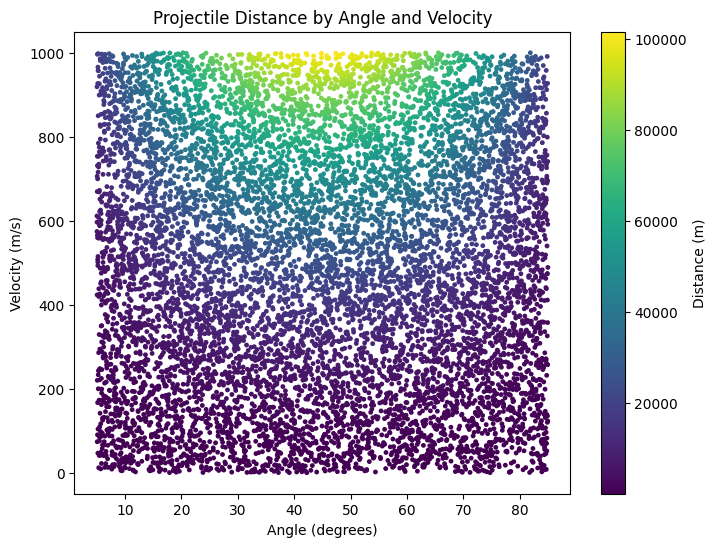

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    inputs[:, 0].numpy(),  # angle
    inputs[:, 1].numpy(),  # velocity
    c=outputs[:, 0].numpy(),  # distance
    cmap='viridis',
    s=6
)
plt.xlabel('Angle (degrees)')
plt.ylabel('Velocity (m/s)')
plt.title('Projectile Distance by Angle and Velocity')
plt.colorbar(sc, label='Distance (m)')
plt.show()
